# argo

## ocean drifter array

### ARGO references

- [GitHub pyARGO](https://github.com/castelao/pyARGO) Rob is not convinced this is complete enough to be useful...
- [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
- [Coriolis map-based data selection tool](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
- [xarray lesson that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)


### Related references

- [My reference notebooks on Python, NetCDF, ipyleaflet, xarray and more](https://github.com/pangeo-data/cmr)
  - This repository also provides a number of additional useful references

In [19]:
%matplotlib inline
import timeit
from datetime import timedelta
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
from pathlib import Path

# geoscience tools
!pip install utm
!pip install pygeotools
import utm

from osgeo import gdal 
from pygeotools.lib import iolib,timelib


home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


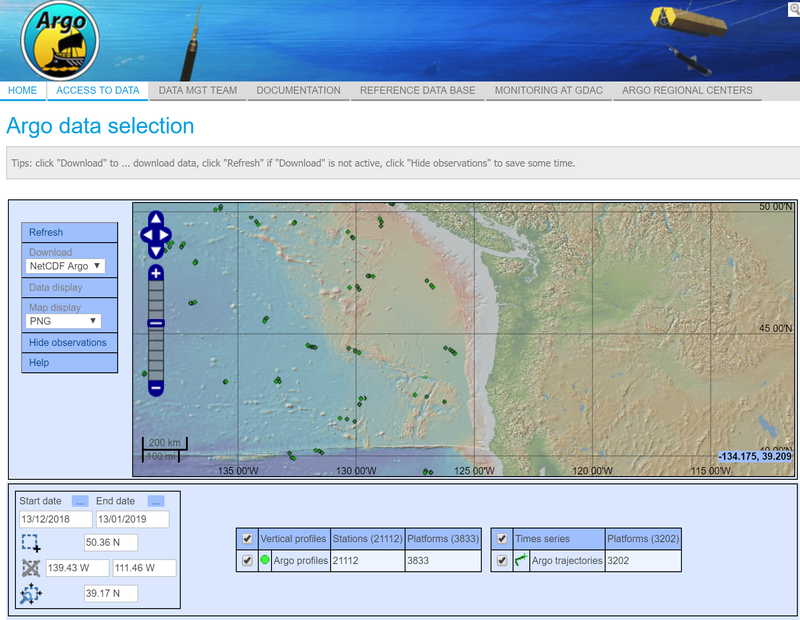

In [2]:
argo_d = data_d + 'argo/'
ShowLocalImage('./','coriolis.png',800,620)

Coriolis interface: An ARGO data selection tool. Stipulate a bounding box and time range; the interface will 
report back with something like this:

```
We are processing your data request.
The data will be delivered: ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190113_173353_7389235.tgz
```


### Details on selecting a dataset using coriolis 

- Use the map interface to select (yellow rectangle) a bounding box. 
- Use the time box to select a time range
- Click on Refresh (control left of map), wait for Query to complete
- Make sure pop-ups are unblocked for this page; then click **Download** to open the Data Selection dialog 
  - Enter your email, click the 'Extract your data' button; you receive...
    - an ftp URL in your browser 
    - a 'processing' confirmation email
    - a 'data ready' email with a link to the dataset
  - While the data is accumulating you can log in to the ftp server and navigate to .../co0501
    - Here find a prep directory that will eventually be converted to a .tgz file
      - In our example ```DataSelection_20190113_173353_7389235```
      - There the NetCDF files accumulate, apparently ten at a time... eventually to fulfill the request
      - The NetCDF files can be pulled directly from this location (see example in cell below)


I searched using the bounding box shown below, time range Jan 1 2016 to -- Jan 13 2019. 
The resulting ftp server URL was

```
ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190113_173353_7389235.tgz
```

This file may expire after some hours (the ftp server then returns merely ```221 Goodbye```). So it 
is possible to ignore the ```.tgz```

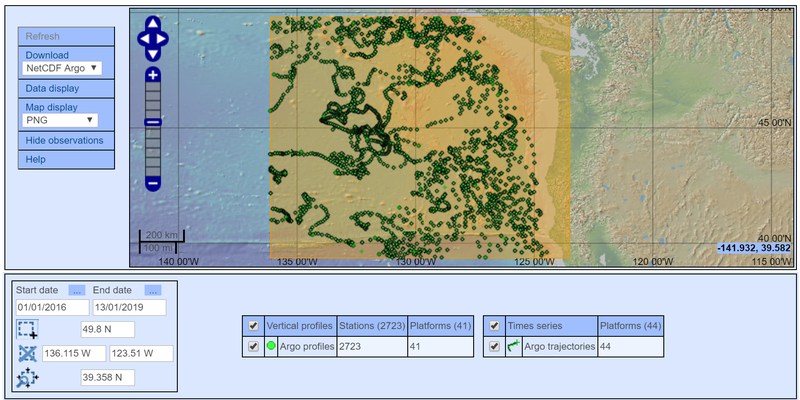

In [3]:
ShowLocalImage('./','coriolis2.png',800,400)

***Coriolis interface showing locations of argo profiles in the search bounding box over 3 years***

In [4]:
if False:
    # A typical search returns an ftp URL like this: 
    #   ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190113_173353_7389235.tgz
    from ftplib import FTP
    dataIDString = '20190113_173353_7389235'
    myIDString = argo_d + 'ARGO_2016_001_2019_013.tgz'
    ftp = FTP('ftp.ifremer.fr')
    ftp.login()                                        # anonymous
    ftp.cwd('ifremer/coriolis/tmp/co0501/')
    ftp.retrlines('LIST DataSelection_' + dataIDString + '.tgz')
    ftp.retrbinary('RETR DataSelection_' + dataIDString + '.tgz', open(myIDString, 'wb').write)
    ftp.quit()

# Another approach using wget is simpler:
if False: 
    !wget ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190113_173353_7389235.tgz

# code to unzip and untar result files
# retvalue = os.popen('gunzip ' + c + '.tgz').readlines()
# retvalue = os.popen('tar -xvf ' + c + '.tar').readlines()
# !tar -xvf coriolis_profiles.tgz
# !rm /data/argo/coriolis_profiles.tgz
# !mkdir /data/argo/profiles
# !mkdir /data/argo/trajectories

In [5]:
# Using (Linux) 'wget' to pull NetCDF files directly from the server
# !wget ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20190113_173353_7389235/*nc

### Large ARGO dataset approach


We translate the **NetCDF** data files (one associated with each drifter) to xarray DataSets. Two methods:


- Use ```xarray.open_mfdataset('*.nc')``` to create a single DataSet ```argo``` that spans *all* the drifters
- Use a for-loop to create a list of DataSets ```argo[]```


Here we use the latter, which is a bit cumbersome requiring iterators to loop over the list. 
The single DataSet approach is not easy to implement. It throws the error


```ValueError: too many different dimensions to concatenate: {'N_LEVELS', 'N_HISTORY', 'N_PROF'}```


This is a reflection of the heterogeneous nature of the ARGO array, i.e. many independent sensor platforms.

In [6]:
# This is code to accumulate filenames for the list approach to the full profile dataset
#   Files containing 'profiles' in the filename are just that
#   Files containing 'trajectory' are smaller files associated with drift tracks (I believe)

sumProfiles, argo, fnms, r = 0, [], [], lsal(argo_d + '*profile*.nc')
for a in r: 
    c = a.split()[8]
    if c not in fnms: 
        fnms.append(c); 
        argo.append(xr.open_mfdataset(c))
        sumProfiles += len(argo[-1].N_PROF.values)

print('From', len(fnms), 'ARGO .nc files we have', sumProfiles, 'profiles')

From 40 ARGO .nc files we have 2541 profiles


## ARGO Python package

As a reminder there is an argo Python package that one could investigate


```
from argo.argo import profile_from_nc
from argo.utils import download_testdata
datafile = download_testdata('20150127_prof.nc')
```

## ARGO Data

The main ARGO data resource is a pair of Global Data Assembly Centers (GDACs) in US and France. 
The data are in NetCDF format and one should use 'D' files when possible (in contrast with 'R' files): 
The D files have been post-processed (quality control).


There are other ways to access ARGO data besides downloading the netCDF files from the GDACs. 
There are gridded fields and velocity products available as well as data viewers developed to look 
at the ARGO dataset. To look at individual float data, use the individual float description tool at Coriolis. 
To select a group of floats within a certain region or time, use one of the data selection tools to the right. 
There is also a beginner's guide to ARGO data.

In [7]:
# Get a sense of the data in the argo[] list
#   Dates of each profile: JULD 
#   CTD us PSAL_ADJUSTED, TEMP_ADJUSTED, PRES_ADJUSTED
#   Other profile data that might be present (PAR, DO, etc) is an open question
q = argo[0]
q                    # just shorthand

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 21, N_LEVELS: 211, N_PARAM: 3, N_PROF: 9)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object dask.array<shape=(9,), chunksize=(9,)>
    PROJECT_NAME                  (N_PROF) object dask.array<shape=(9,), chunksize=(9,)>
    PI_NAME                       (N_PROF) object dask.array<shape=(9,), chunksize=(9,)>
    STATION_PARAMETERS            (N_PROF, N_PARAM) object dask.array<shape=(9, 3), chunksize=(9, 3)>
    CYCLE_NUMBER                  (N_PROF) float64 dask.array<shape=(9,), chunksize=(9,)>
    DIRECTION                     (N_PROF) object dask.array

CPU times: user 35.5 s, sys: 735 ms, total: 36.3 s
Wall time: 36.5 s


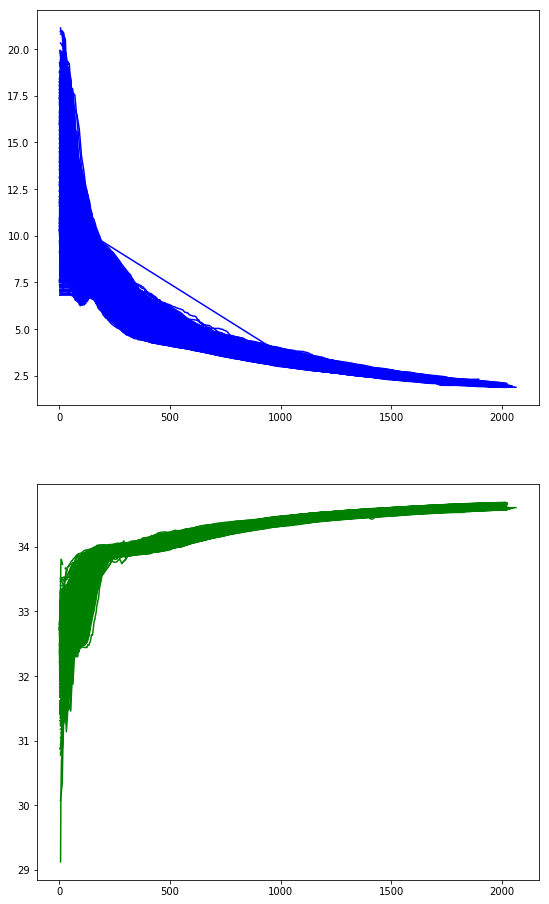

In [8]:
%%time

# this is a check that CTD data are present in the passed DataSet d
#   Note also that 'hasattr(obj, parameter)' is also a way of filtering the data for other types of observation
#   provided you know what they are called.
def HasCTD(d): return(hasattr(d, 'PRES_ADJUSTED') and hasattr(d, 'TEMP_ADJUSTED') and hasattr(d, 'PSAL_ADJUSTED'))

# print(type(d['TEMP_ADJUSTED'])) will indicate an xarray DataArray
# print(d['TEMP_ADJUSTED'].values) will print temperatures in deg C across all profiles and their depths

# Using the sub-plot mechanism we show both temperature and salinity with depth
fig,ax = plt.subplots(2,1)
fig.set_size_inches(9,16)
for i in range(len(argo)):
    this = argo[i]
    if HasCTD(this):
        for j in range(len(this.N_PROF.values)):
            temp = this.TEMP_ADJUSTED[j].values
            pressure = this.PRES_ADJUSTED[j].values
            salinity = this.PSAL_ADJUSTED[j].values
            ax[0].plot(pressure, temp, color='b')
            ax[1].plot(pressure, salinity, color='g')
    else: print('dataset', i, 'has a CTD error; file is', fnms[i])

In [9]:
# Using the sub-plot mechanism we show both temperature and salinity with depth
# Using nested slider widgets the Drifter / Dataset slider selects one of our ARGO drifters
#   and the Profile slider adjusts its allowed range to the number of profiles for that drifter.
# This also uses a Checkbox() to allow you to switch to un-ADJUSTED versions of the data. In 
#   some case this is all that is available (see ARGO index 23 for example).
# The code allows you to switch _ADJUSTED on and off without resetting the ARGO / PROFILE counter.

dsI = 0
profile = 0
useAdjusted = True

def TCPlot(profileIndex):
    global dsI, useAdjusted, profile
    profile = profileIndex
    datestring = str(argo[dsI].JULD[profileIndex].values).split('T')[0]
    yloc = 18.
    xloc = 1500.
    fig,ax = plt.subplots(2,1)
    fig.set_size_inches(8,8)
    if useAdjusted: 
        temp = argo[dsI].TEMP_ADJUSTED[profile].values
        pressure = argo[dsI].PRES_ADJUSTED[profile].values
        salinity = argo[dsI].PSAL_ADJUSTED[profile].values
    else:
        temp = argo[dsI].TEMP[profile].values
        pressure = argo[dsI].PRES[profile].values
        salinity = argo[dsI].PSAL[profile].values        
    ax[0].plot(pressure, temp, color='b')
    ax[0].text(xloc, yloc, datestring, color='k')
    ax[0].set(ylim=(2., 20.), xlim=(0., 2000.))
    ax[1].plot(pressure, salinity, color='g')
    ax[1].set(ylim=(32., 35.), xlim=(0., 2000.))
    
def ProfileSelector(dsIndex, adjusted): 
    global dsI, useAdjusted
    dsI = dsIndex
    useAdjusted = adjusted
    nProfiles = len(argo[dsIndex].N_PROF.values)
    interact(TCPlot, profileIndex=widgets.IntSlider(min=0, max = nProfiles - 1, value = profile, 
                continuous_update = False, description = 'Profile'))
    
interact(ProfileSelector, 
         adjusted=widgets.Checkbox(value=True, continuous_update=False, description='Use ADJUSTED data'),
         dsIndex=widgets.IntSlider(min=0,max=len(argo)-1, value=dsI, continuous_update=False, description='Dataset'))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Dataset', max=39), Checkbox(val…

<function __main__.ProfileSelector>

In [10]:
# The above is suggestive of stacking profiles with little offsets

In [11]:
q=argo[23]
q

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 8, N_LEVELS: 1011, N_PARAM: 3, N_PROF: 28)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object dask.array<shape=(28,), chunksize=(28,)>
    PROJECT_NAME                  (N_PROF) object dask.array<shape=(28,), chunksize=(28,)>
    PI_NAME                       (N_PROF) object dask.array<shape=(28,), chunksize=(28,)>
    STATION_PARAMETERS            (N_PROF, N_PARAM) object dask.array<shape=(28, 3), chunksize=(28, 3)>
    CYCLE_NUMBER                  (N_PROF) float64 dask.array<shape=(28,), chunksize=(28,)>
    DIRECTION                     (N_PROF) object

In [12]:
# works: q['LATITUDE'].values
qlats=q['LATITUDE'].values.tolist()
qlons=q['LONGITUDE'].values.tolist()
qcoords = [[qlats[i],qlons[i]] for i in range(len(qlats))]
qcoords


[[40.0026, -132.79882],
 [40.0026, -132.79882],
 [39.99532, -132.77696],
 [39.99532, -132.77696],
 [40.00327, -132.72256],
 [40.00327, -132.72256],
 [40.01565, -132.68607],
 [40.01565, -132.68607],
 [40.020779999999995, -132.64746],
 [40.020779999999995, -132.64746],
 [40.02536, -132.23372],
 [40.02536, -132.23372],
 [40.132439999999995, -131.88329],
 [40.132439999999995, -131.88329],
 [40.14707, -131.56383],
 [40.14707, -131.56383],
 [40.092949999999995, -131.39391],
 [40.092949999999995, -131.39391],
 [39.935559999999995, -131.23022],
 [39.935559999999995, -131.23022],
 [39.80034, -131.16591],
 [39.80034, -131.16591],
 [39.69155, -131.23069],
 [39.69155, -131.23069],
 [39.60151, -131.33242],
 [39.60151, -131.33242],
 [39.51454, -131.51667],
 [39.51454, -131.51667]]

[[1.04000e+00 1.84000e+00 2.92000e+00 ...         nan         nan
          nan]
 [2.80000e-01 4.80000e-01 6.80000e-01 ...         nan         nan
          nan]
 [9.60000e-01 2.00000e+00 2.96000e+00 ...         nan         nan
          nan]
 ...
 [8.00000e-01 9.20000e-01 1.00000e+00 ...         nan         nan
          nan]
 [1.12000e+00 2.04000e+00 3.04000e+00 ... 2.00596e+03 2.00740e+03
          nan]
 [8.00000e-01 9.20000e-01 1.28000e+00 ...         nan         nan
          nan]]


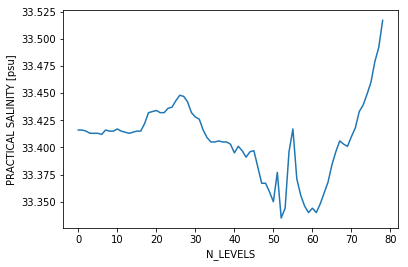

In [13]:
print(q['PRES'].values)
q['PSAL'][0].plot()

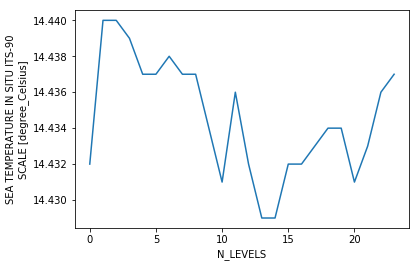

In [14]:
q['TEMP'][1].plot()

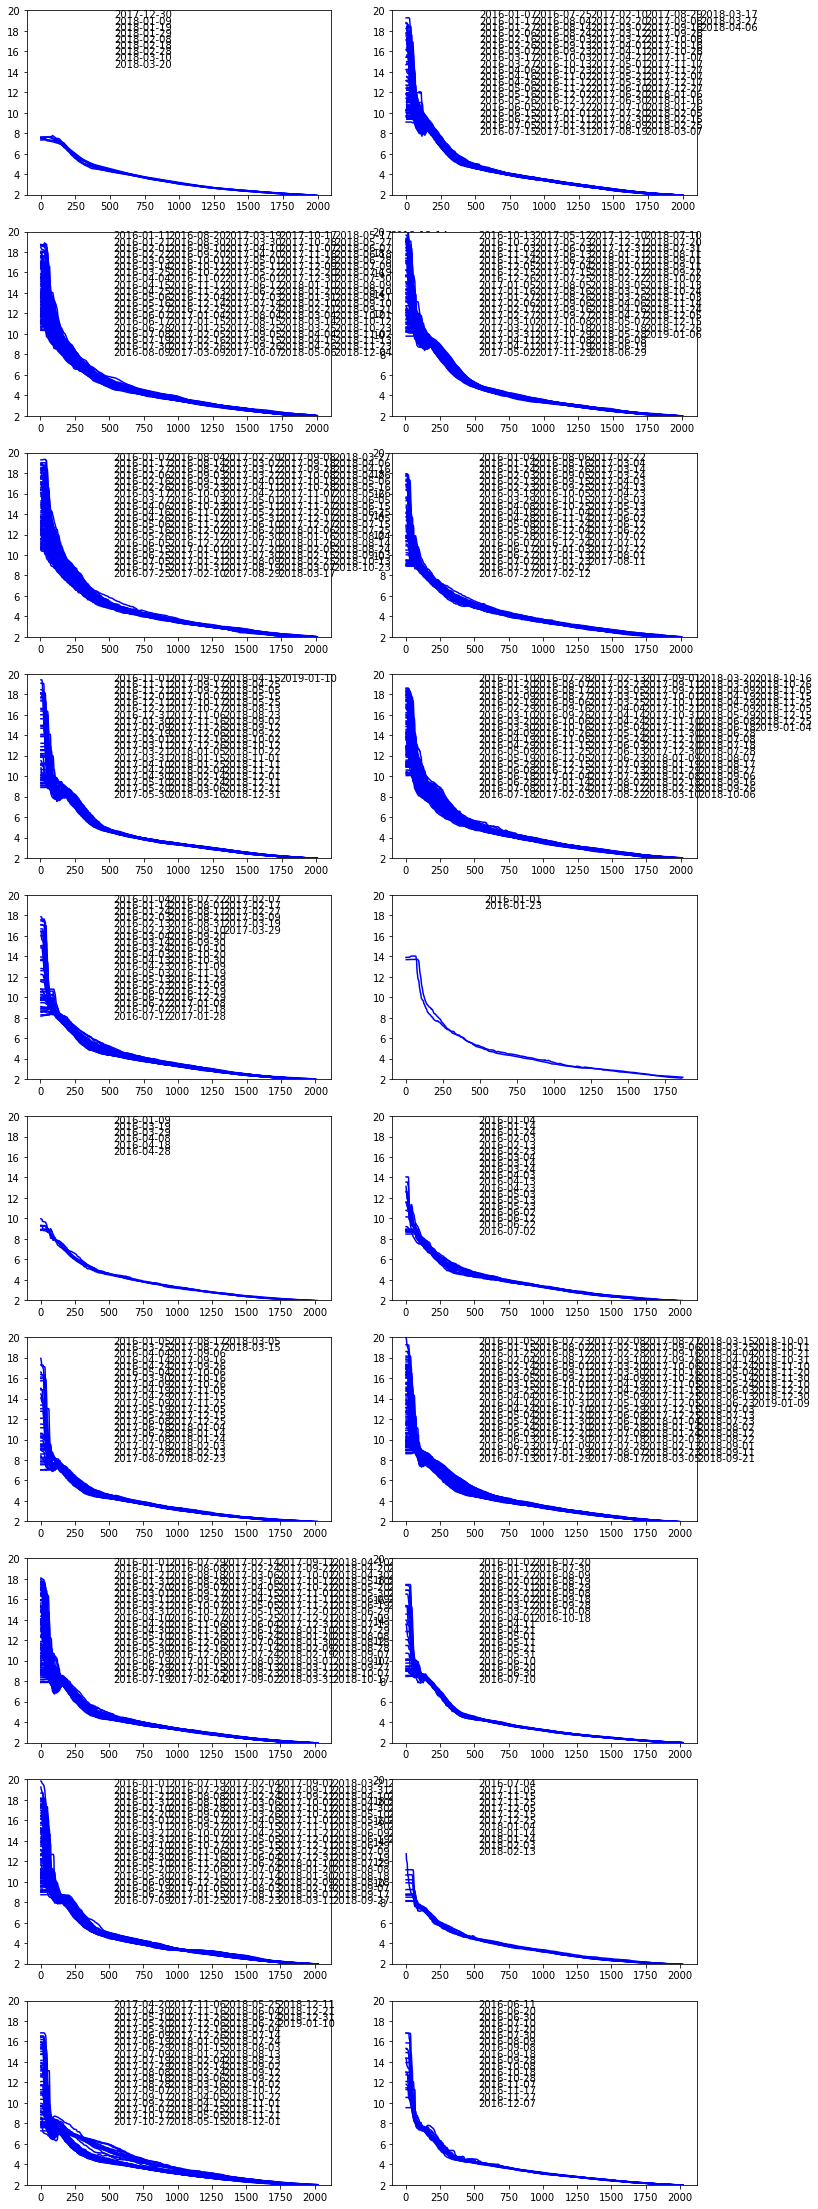

In [15]:
nAcross = 2
nDown = int(len(argo)/2.+0.5)

nDown = 10

fig,axes = plt.subplots(nDown, nAcross)
fig.set_size_inches(12,40)

# for p in range(len(argo)):
for p in range(20):
    n = len(argo[p].N_PROF.values)
    plotCol = p%2
    plotRow = p//2
    axes[plotRow, plotCol].set(ylim=(2., 20.))
    for i in range(n):
        temp=argo[p].TEMP_ADJUSTED[i].values
        pressure=argo[p].PRES_ADJUSTED[i].values
        datestring = str(argo[p].JULD[i].values).split('T')[0]
        yloc = 19.3-0.6*(i%20)
        xloc = 530. + 400.*(i//20)
        axes[plotRow, plotCol].plot(pressure, temp, color='b')
        axes[plotRow, plotCol].text(xloc, yloc, datestring, color='k')

In [16]:
a=argo[38]
# print(a) prints everything
# print(a['JULD'].values) prints an ndarray of UTC timestamps
print(a['JULD'].values[17])   # just one

mydt = a['JULD'].values[17]
print(mydt, type(mydt), '\n')

b = a['TEMP_ADJUSTED'][16:18,100:103].where(True)
print(b, type(b), '\n')
print(b.values)
# .sel(JULD=datetime, method='nearest')
# trying to filter by Julian Day cf http://xarray.pydata.org/en/stable/indexing.html

2016-04-03T10:13:44.000000000
2016-04-03T10:13:44.000000000 <class 'numpy.datetime64'> 

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 2, N_LEVELS: 3)>
dask.array<shape=(2, 3), dtype=float32, chunksize=(2, 3)>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       SEA TEMPERATURE IN SITU ITS-90 SCALE
    standard_name:   sea_water_temperature
    units:           degree_Celsius
    valid_min:       -2.0
    valid_max:       40.0
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    resolution:      0.001 <class 'xarray.core.dataarray.DataArray'> 

[[7.6   7.576 7.54 ]
 [7.441 7.398 7.355]]


In [17]:
argo[4]['TEMP'].to_dataframe()

TEMP
N_PROF N_LEVELS        
0      0         13.611
       1         13.610
       2         13.606
       3         13.607
       4         13.612
       5         13.614
       6         13.616
       7         13.612
       8         13.611
       9         13.610
       10        13.609
       11        13.608
       12        13.609
       13        13.609
       14        13.608
       15        13.611
       16        13.610
       17        13.611
       18        13.610
       19        13.609
       20        13.611
       21        13.608
       22        13.596
       23        13.582
       24        13.586
       25        13.587
       26        13.555
       27        13.538
       28        13.501
       29        13.452
...                 ...
98     976        1.965
       977        1.964
       978        1.964
       979        1.964
       980        1.963
       981        1.962
       982        1.961
       983        1.958
       984        1.957
       985        1.954
       986        1.951
       987        1.950
       988        1.948
       989        1.948
       990        1.947
       991        1.945
       992        1.943
       993        1.942
       994        1.939
       995        1.938
       996        1.936
       997        1.932
       998        1.931
       999        1.930
       1000       1.930
       1001         NaN
       1002         NaN
       1003         NaN
       1004         NaN
       1005         NaN

[99594 rows x 1 columns]

#### Establishing a map


What follows below creates an ipyleaflet map with some interactive controls. It establishes that the
interact() method can be called multiple times; where the respective control sliders are all present.

In [18]:
opacity = 0.6
lllat = 32.18
lllon = -146.39
urlat = 50.35
urlon = -114.28

def ChangeMapOpacity(opac):
    global opacity
    opacity = opac
    thisMap.layers[1].opacity = opacity
    
def ChangeCorners(a, b, c, d):
    global lllat, lllon, urlat, urlon
    lllat = a
    lllon = b
    urlat = c
    urlon = d
    thisMap.layers[1].bounds=[(lllat, lllon), (urlat, urlon)]
    ChangeMapOpacity(0.6)

from ipyleaflet import Map, ImageOverlay, WMSLayer, Polyline

thisMap = Map(center=(45, -130), zoom=5, layout=Layout(width='100%', height='600px'))
# The path to the image for overlay is relative; I could not get an absolute path to work...
sourceImage =  'coriolis2.png'
image_layer = ImageOverlay(url=sourceImage, bounds=((lllat, lllon), (urlat, urlon)), opacity=opacity)
thisMap.add_layer(image_layer)

for i in range(len(argo)):
    qlats=argo[i]['LATITUDE'].values.tolist()
    qlons=argo[i]['LONGITUDE'].values.tolist()
    qcoords = [[qlats[i],qlons[i]] for i in range(len(qlats))]
    thisMap.add_layer(Polyline(locations = [[qcoords,]], color = "black", fill_color="blue", fill = False, weight=2))

interact(ChangeMapOpacity, 
    opac = widgets.FloatSlider(min=0., max=1., step=0.025, value=opacity, continuous_update=False, display='Opacity'),
        )

interact(ChangeCorners, 
    a = widgets.FloatSlider(min = lllat - 0.5, max = lllat + 0.5, step=0.005, value=lllat, continuous_update=False, display='lat'),
    b = widgets.FloatSlider(min = lllon - 0.5, max = lllon + 0.5, step=0.005, value=lllon, continuous_update=False, display='lon'),
    c = widgets.FloatSlider(min = urlat - 0.5, max = urlat + 0.5, step=0.005, value=urlat, continuous_update=False, display='lat'),
    d = widgets.FloatSlider(min = urlon - 0.5, max = urlon + 0.5, step=0.005, value=urlon, continuous_update=False, display='lon'))


# It seems that 'thisMap' must be the last line of code in the cell, hence placing interact() above
thisMap

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='opac', max=1.0, step=0.025)…

interactive(children=(FloatSlider(value=32.18, continuous_update=False, description='a', max=32.68, min=31.68,…

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [19]:
print(thisMap.layers[1])

ImageOverlay(bounds=[(32.18, -146.39), (50.35, -114.28)], opacity=0.6, options=['attribution'], url='coriolis2.png')
